In [1]:
import gym
from gym import envs
env = gym.make('Blackjack-v0')


In [2]:
dir(env)
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

# Задание 1
Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. 

Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


In [3]:
import numpy as np

debug =  False
results = []
num_iter = 500000

for i in range(num_iter):
    cur, dealer, space = env.reset()
    
    if debug: print("start", cur, dealer, space)
    
    is_finished = False
    while cur <= 18:
        state, score, is_finished, some =  env.step(1)
        cur = state[0]
        if debug: print("more", cur, score, is_finished, some)
    
    if is_finished:
        results.append(score)
    else:
        state, score, is_finished, some = env.step(0)
        if debug: print("stop", state, score, is_finished, some)  
        assert is_finished == True
        results.append(score)

print(f'средний выигрыш по стратегии {np.mean(np.array(results))}') 

средний выигрыш по стратегии -0.199458


Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [4]:
num_states = 32*11*2
num_actions = 2

def get_code_by_state(state):
    return state[0]*22 + state[1] *2 + (1 if state[2] else 0) 

def get_state_by_code(code):
    is_ace = True if code%2 == 1 else False
    dealer = (int(code/2))%11
    player = int(code/22)
    return (player, dealer, is_ace)

def egreedy_policy(q_values, state, epsilon=0.1):  
    if np.random.random() < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(q_values[state])


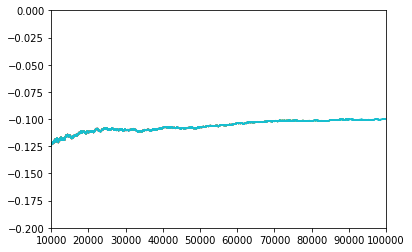

last_avg_reward -0.10016000000000015


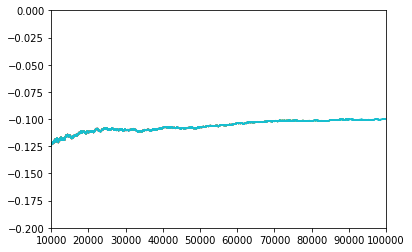

In [5]:
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display


def conduct_experiment(learning_rate = 0.05, epsilon = 0.1, num_iterations = 100000, plot = False, debug = False):
    print(f'начинаем эксперимент, lr = {learning_rate} epsilon = {epsilon} num_iter = {num_iterations}')
    avg_rewards = []
    q_values = np.zeros((num_states, num_actions))
    states_counter = np.zeros((num_states, num_actions))
    for _ in range(num_iterations):
        state = env.reset()    
        if debug: print("New Game")
        state_code = get_code_by_state(state)
        if debug: print(state, "->", state_code)

        done = False

        while not done:
            action = egreedy_policy(q_values, state_code, epsilon)
            if debug: print("action", action)

            next_state, reward, done, some = env.step(action)

            next_state_code = get_code_by_state(next_state)

            if debug: print("next_state", next_state, reward, done, some, next_state_code, q_values[next_state_code][:])
            if debug: print("old value", q_values[state_code][:], reward, np.max(q_values[next_state_code]))            

            q_values[state_code][action] += learning_rate * (reward + np.max(q_values[next_state_code][:] if not done else 0) - q_values[state_code][action])
            states_counter[state_code][action] += 1

            if debug: print("new value", q_values[state_code][:])

            state_code = next_state_code
            if done == True:
                if len(avg_rewards) == 0:
                    avg_rewards.append(reward)
                else:
                    avg_rewards.append((avg_rewards[-1] * len(avg_rewards) + reward)/(len(avg_rewards)+1))

        if len(avg_rewards)%10000 == 0 and plot:
            pl.plot(avg_rewards)
            pl.xlim(10000, num_iterations)
            pl.ylim(-0.2,0)
            display.clear_output(wait=True)
            display.display(pl.gcf())
    print(f'last_avg_reward {avg_rewards[-1]}')
    return avg_rewards, states_counter, q_values
    
avg_rewards, states_counter, q_values = conduct_experiment(learning_rate = 0.05, epsilon = 0.1, num_iterations = 100000, debug = False, plot = True)


In [6]:
# пройдемся по посещенным состояниям и выведем Q
for i in range(num_states):
    if np.max(states_counter[i][:]) > 0:
        print(get_state_by_code(i), " assessment ", q_values[i][:], states_counter[i], np.argmax(q_values[i]), round(q_values[i][np.argmax(q_values[i])],2))

(4, 1, False)  assessment  [-0.38542442 -0.34908971] [15. 34.] 1 -0.35
(4, 2, False)  assessment  [-0.2275374  -0.09324422] [15. 28.] 1 -0.09
(4, 3, False)  assessment  [-0.11903663 -0.12256536] [11. 28.] 0 -0.12
(4, 4, False)  assessment  [-0.14476844 -0.10430555] [ 5. 40.] 1 -0.1
(4, 5, False)  assessment  [ 0.0301323  -0.01586914] [11. 31.] 0 0.03
(4, 6, False)  assessment  [-0.142625   -0.02359227] [ 3. 35.] 1 -0.02
(4, 7, False)  assessment  [-0.17917061 -0.07093896] [ 6. 39.] 1 -0.07
(4, 8, False)  assessment  [-0.16674584 -0.11568226] [ 8. 28.] 1 -0.12
(4, 9, False)  assessment  [-0.18345748 -0.16722968] [ 6. 34.] 1 -0.17
(4, 10, False)  assessment  [-0.45623952 -0.30744128] [ 30. 133.] 1 -0.31
(5, 1, False)  assessment  [-0.53544638 -0.44588007] [23. 59.] 1 -0.45
(5, 2, False)  assessment  [-0.2114561  -0.21017595] [20. 63.] 1 -0.21
(5, 3, False)  assessment  [-0.05002389 -0.11874249] [35. 65.] 0 -0.05
(5, 4, False)  assessment  [ 0.11582086 -0.09654595] [23. 77.] 0 0.12
(5, 5,

Поподбираем гиперпараметры, но в целом на миллионе итераций максимум вышел на learnnig_rate 0.01 и таким же epsilon, мельче я не дробил. Оставлю тут код для более широкого range

начинаем эксперимент, lr = 0.01 epsilon = 0.02 num_iter = 100000
last_avg_reward -0.07902000000000162
начинаем эксперимент, lr = 0.01 epsilon = 0.04 num_iter = 100000
last_avg_reward -0.0881000000000001
начинаем эксперимент, lr = 0.01 epsilon = 0.06 num_iter = 100000
last_avg_reward -0.0951400000000003
начинаем эксперимент, lr = 0.01 epsilon = 0.08 num_iter = 100000
last_avg_reward -0.09684000000000008
начинаем эксперимент, lr = 0.01 epsilon = 0.1 num_iter = 100000
last_avg_reward -0.10000999999999949
начинаем эксперимент, lr = 0.04 epsilon = 0.02 num_iter = 100000
last_avg_reward -0.08052999999999945
начинаем эксперимент, lr = 0.04 epsilon = 0.04 num_iter = 100000
last_avg_reward -0.08335000000000058
начинаем эксперимент, lr = 0.04 epsilon = 0.06 num_iter = 100000
last_avg_reward -0.0894399999999995
начинаем эксперимент, lr = 0.04 epsilon = 0.08 num_iter = 100000
last_avg_reward -0.09855999999999979
начинаем эксперимент, lr = 0.04 epsilon = 0.1 num_iter = 100000
last_avg_reward -0.101

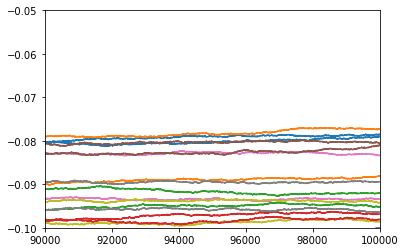

In [7]:
for learning_rate in np.linspace(0.01, 0.1, 4):
    for epsilon in np.linspace(0.02, 0.1, 5):
        avg_rewards, states_counter, q_values = conduct_experiment(learning_rate, epsilon)
        plt.plot(avg_rewards, label = f'lr={learning_rate}, eps = {epsilon}')
        
plt.xlim(90000, 100000)
plt.ylim(-0.1,-0.05)
plt.show()

# Задание 2

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. 

Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. 

Итак, у игрока появляется дополнительное действие:
double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


Просто добавим в класс метод step_new

In [8]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    # добавим новый метод, так проще всего реализовать
    def step_new(self, action):
        if self.action_space.contains(action):
            return self.step(action)
        else:
            state, reward, done, empty = self.step(1)
            if done:
                return state, reward * 2, done, empty
            else:
                state, reward, done, empty = self.step(0)
                assert done==True
                return state, reward * 2, done, empty

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()


In [9]:
env = BlackjackEnv()
env.reset()

(5, 8, False)

In [10]:
# переопределим число действий
num_actions = 3

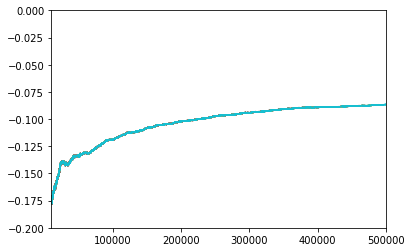

last_avg_reward -0.08658799999999903


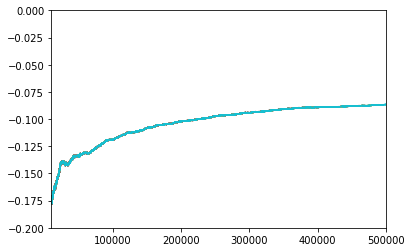

In [12]:
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display


def conduct_experiment_double(learning_rate = 0.05, epsilon = 0.1, num_iterations = 100000, plot = False, debug = False):
    print(f'начинаем эксперимент, lr = {learning_rate} epsilon = {epsilon} num_iter = {num_iterations}')
    avg_rewards = []
    q_values = np.zeros((num_states, num_actions))
    states_counter = np.zeros((num_states, num_actions))
    for _ in range(num_iterations):
        state = env.reset()    
        if debug: print("New Game")
        state_code = get_code_by_state(state)
        if debug: print(state, "->", state_code)

        done = False

        while not done:
            action = egreedy_policy(q_values, state_code, epsilon)
            if debug: print("action", action)

            next_state, reward, done, some = env.step_new(action)

            next_state_code = get_code_by_state(next_state)

            if debug: print("next_state", next_state, reward, done, some, next_state_code, q_values[next_state_code][:])
            if debug: print("old value", q_values[state_code][:], reward, np.max(q_values[next_state_code]))            

            q_values[state_code][action] += learning_rate * (reward + np.max(q_values[next_state_code][:] if not done else 0) - q_values[state_code][action])
            states_counter[state_code][action] += 1

            if debug: print("new value", q_values[state_code][:])

            state_code = next_state_code
            if done == True:
                if len(avg_rewards) == 0:
                    avg_rewards.append(reward)
                else:
                    avg_rewards.append((avg_rewards[-1] * len(avg_rewards) + reward)/(len(avg_rewards)+1))

        if len(avg_rewards)%10000 == 0 and plot:
            pl.plot(avg_rewards)
            pl.xlim(10000, num_iterations)
            pl.ylim(-0.2,0)
            display.clear_output(wait=True)
            display.display(pl.gcf())
    print(f'last_avg_reward {avg_rewards[-1]}')
    return avg_rewards, states_counter, q_values
    
avg_rewards, states_counter, q_values = conduct_experiment_double(learning_rate = 0.01, epsilon = 0.04, num_iterations = 500000, debug = False, plot = True)


In [13]:
# пройдемся по посещенным состояниям и выведем Q
for i in range(num_states):
    if np.max(states_counter[i][:]) > 0:
        print(get_state_by_code(i), " assessment ", q_values[i][:], states_counter[i], np.argmax(q_values[i]), round(q_values[i][np.argmax(q_values[i])],2))

(4, 1, False)  assessment  [-0.30071916 -0.29531901 -0.31173612] [ 64. 138.  21.] 1 -0.3
(4, 2, False)  assessment  [-0.10549446 -0.08126017 -0.135489  ] [108. 123.  11.] 1 -0.08
(4, 3, False)  assessment  [-0.06424552 -0.0436776  -0.05910524] [ 19. 180.  17.] 1 -0.04
(4, 4, False)  assessment  [-0.06422998 -0.0411807  -0.05635814] [ 21. 196.  11.] 1 -0.04
(4, 5, False)  assessment  [-0.058614   -0.03627446 -0.04104283] [  8. 197.  28.] 1 -0.04
(4, 6, False)  assessment  [-0.00920995  0.03824351 -0.0586257 ] [  5. 207.   7.] 1 0.04
(4, 7, False)  assessment  [-0.12934922 -0.0930625  -0.15395324] [ 43. 168.  10.] 1 -0.09
(4, 8, False)  assessment  [-0.13532187 -0.12231171 -0.14445163] [ 25. 166.  33.] 1 -0.12
(4, 9, False)  assessment  [-0.16764473 -0.17103296 -0.17296551] [ 51. 151.   9.] 0 -0.17
(4, 10, False)  assessment  [-0.3615302  -0.34576074 -0.41067335] [104. 725.  62.] 1 -0.35
(5, 1, False)  assessment  [-0.44602187 -0.41922276 -0.49056143] [ 78. 345.  28.] 1 -0.42
(5, 2, Fals


Видно что удваивать иногда имеет смысл только если при сдаче выпаало 10 или 11 очков

Снова у меня получился лучший результат при epsilon = 0.01 для миллиона испытаний, так что ооставлю тут только его

начинаем эксперимент, lr = 0.01 epsilon = 0.01 num_iter = 500000
last_avg_reward -0.06832399999999822
начинаем эксперимент, lr = 0.02 epsilon = 0.01 num_iter = 500000
last_avg_reward -0.06988400000000093
начинаем эксперимент, lr = 0.03 epsilon = 0.01 num_iter = 500000
last_avg_reward -0.0704739999999989
начинаем эксперимент, lr = 0.04 epsilon = 0.01 num_iter = 500000
last_avg_reward -0.07027999999999916
начинаем эксперимент, lr = 0.05 epsilon = 0.01 num_iter = 500000
last_avg_reward -0.06967600000000146


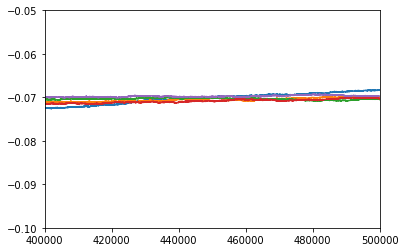

In [15]:
for learning_rate in np.linspace(0.01, 0.05, 5):
    #for epsilon in np.linspace(0.01, 0.03, 3):
        epsilon = 0.01
        avg_rewards, states_counter, q_values = conduct_experiment_double(learning_rate, epsilon, 500000)
        plt.plot(avg_rewards, label = f'lr={learning_rate}, eps = {epsilon}')
        
plt.xlim(400000, 500000)
plt.ylim(-0.1,-0.05)
plt.show()

# Задание 3

Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [16]:
import gym
from gym import spaces
from gym.utils import seeding
import random
import numpy as np
from collections import Counter


def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10

deck_new = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv_real(gym.Env):
    def __init__(self, debug = False, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
        self.natural = natural
        # Start the first game
        # это индекс карты которая будет сдана следующей
        self.current_indedx = 0
        # поместим колоду внутрь класса
        self.deck = deck_new.copy()
        self.debug = debug
        self.init_deck()
        self.reset()
        if self.debug: print("finish init")

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
                
        return self._get_obs(), reward, done, self.current_index

    # добавим новый метод т.к. все сформулировано в его методах
    def step_new(self, action):
        if self.action_space.contains(action):
            return self.step(action)
        else:
            state, reward, done, empty = self.step(1)
            if not done:
                state, reward, done, empty = self.step(0)

            return state, reward * 2, done, self.current_index

    def _get_obs(self):
        # out_cards -то что вышло до начала розыгрыша
        out_cards = Counter(self.deck[0:self.current_index - len(self.player) - len(self.dealer)])
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), (self.player, self.dealer, out_cards))

    def reset(self):
        self.check_deck()
        self.dealer = self.draw_hand() 
        self.player = self.draw_hand()
        return self._get_obs()
    
    def init_deck(self):
        self.current_index = 0
        self.deck = deck_new.copy()
        random.shuffle(self.deck)
        if self.debug: print(self.deck)


    def check_deck(self):
    # если карт мало и мы закончили - достаем колоду
        if 52 - self.current_index < 15:
            self.init_deck()    

    def draw_card(self):
        card = self.deck[self.current_index]
        self.current_index += 1
        return card

    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]


Сначала просто помоделируем игры, чтобы убедиться, что все запрогано верно

In [17]:
debug =  True
env = BlackjackEnv_real(debug)
env.init_deck()


results = []
num_iter = 10

for i in range(num_iter):
    cur, dealer, space, played_cards = env.reset()
    
    if debug: print("start", cur, dealer, space)
    
    is_finished = False
    while cur <= 18:
        state, reward, is_finished, index =  env.step(1)
        cur = state[0]
        if debug: print("more", cur, reward, is_finished, index)
    
    if is_finished:
        if debug: print("stop", state, reward, is_finished, index)  
        results.append(reward)
    else:
        state, reward, is_finished, index = env.step(0)
        if debug: print("stop", state, reward, is_finished, index)  
        assert is_finished == True
        results.append(reward)
print(np.mean(np.array(results)))  

[3, 2, 2, 4, 10, 2, 7, 4, 3, 8, 10, 6, 10, 10, 10, 1, 6, 8, 4, 10, 9, 1, 5, 5, 10, 9, 10, 10, 5, 3, 1, 5, 9, 6, 7, 7, 2, 10, 10, 10, 9, 8, 4, 10, 6, 7, 8, 3, 1, 10, 10, 10]
finish init
[6, 7, 1, 3, 10, 6, 10, 8, 2, 3, 3, 2, 8, 9, 7, 10, 7, 9, 10, 10, 10, 4, 6, 4, 6, 3, 7, 10, 10, 10, 4, 8, 5, 9, 8, 10, 1, 4, 1, 5, 10, 5, 10, 2, 9, 5, 10, 1, 10, 10, 2, 10]
start 14 6 True
more 14 0.0 False 5
more 20 0.0 False 6
stop (20, 6, False, ([1, 3, 10, 6], [6, 7, 10], Counter())) 1.0 True 7
start 6 8 False
more 8 0.0 False 12
more 16 0.0 False 13
more 25 -1.0 True 14
stop (25, 8, False, ([3, 3, 2, 8, 9], [8, 2], Counter({6: 2, 10: 2, 7: 1, 1: 1, 3: 1}))) -1.0 True 14
start 16 7 False
more 26 -1.0 True 19
stop (26, 7, False, ([7, 9, 10], [7, 10], Counter({3: 3, 6: 2, 10: 2, 8: 2, 2: 2, 7: 1, 1: 1, 9: 1}))) -1.0 True 19
start 10 10 False
more 14 0.0 False 24
more 20 0.0 False 25
stop (20, 10, False, ([4, 6, 4, 6], [10, 10], Counter({10: 4, 7: 3, 3: 3, 6: 2, 8: 2, 2: 2, 9: 2, 1: 1}))) 0.0 True 25
st

Тест на предыдущей задаче

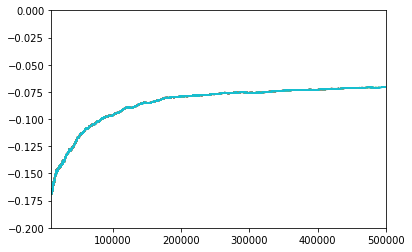

last_avg_reward -0.07039800000000035


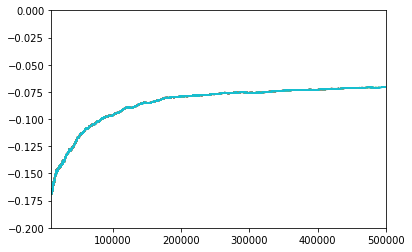

In [18]:
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display

num_states = 32*11*2
num_actions = 3


def get_code_by_state(state):
    state_dims = [32 ,11, 2]
    states = [state[0], state[1], (1 if state[2] else 0)]
    
    state_code = states[0]
    for i in range(1, len(states)):
        state_code = state_code * state_dims[i] + states[i]
    return state_code 


def get_state_by_code(code):
    state_dims = [32 ,11, 2]
    result = []

    for i in range(len(state_dims)-1, -1, -1):
        result.append(code%state_dims[i])
        code = int(code/state_dims[i])
    result.reverse()
    return tuple(result)


def egreedy_policy(q_values, state, epsilon=0.1):  
    if np.random.random() < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(q_values[state])


def conduct_experiment_double(learning_rate = 0.05, epsilon = 0.1, num_iterations = 100000, plot = False, debug = False):
    print(f'начинаем эксперимент, lr = {learning_rate} epsilon = {epsilon} num_iter = {num_iterations}')
    avg_rewards = []
    q_values = np.zeros((num_states, num_actions))
    states_counter = np.zeros((num_states, num_actions))
    for _ in range(num_iterations):
        state = env.reset()    
        if debug: print("New Game")
        state_code = get_code_by_state(state)
        if debug: print(state, "->", state_code)

        done = False

        while not done:
            action = egreedy_policy(q_values, state_code, epsilon)
            if debug: print("action", action)

            next_state, reward, done, index = env.step_new(action)
            next_state_code = get_code_by_state(next_state)

            if debug: print("next_state", next_state, reward, done, some, next_state_code, q_values[next_state_code][:])
            if debug: print("old value", q_values[state_code][:], reward, np.max(q_values[next_state_code]))            

            q_values[state_code][action] += learning_rate * (reward + np.max(q_values[next_state_code][:] if not done else 0) - q_values[state_code][action])
            states_counter[state_code][action] += 1

            if debug: print("new value", q_values[state_code][:])

            state_code = next_state_code
            if done == True:
                if len(avg_rewards) == 0:
                    avg_rewards.append(reward)
                else:
                    avg_rewards.append((avg_rewards[-1] * len(avg_rewards) + reward)/(len(avg_rewards)+1))

        if len(avg_rewards)%10000 == 0 and plot:
            pl.plot(avg_rewards)
            pl.xlim(10000, num_iterations)
            pl.ylim(-0.2,0)
            display.clear_output(wait=True)
            display.display(pl.gcf())
    print(f'last_avg_reward {avg_rewards[-1]}')
    return avg_rewards, states_counter, q_values


debug = False
env = BlackjackEnv_real(debug)
env.init_deck()
avg_rewards, states_counter, q_values = conduct_experiment_double(learning_rate = 0.02, epsilon = 0.02, num_iterations = 500000, debug = debug, plot = True)

+- сошлось

Попробуем сделать как "замечательной книге Стэнфорда Уонга", также сгруппируем по числу карт до начала игры:
[15, 23] [24, 34] [35, 52] по картам [, -7.5] [-7.5, -4.5] [-4.5, -1.5] [-1.5, 1.5] [1.5, 4.5] [4.5, 7.5] [7.5 , +]

In [19]:
def cards_score(card):
    if card in [2, 7]: 
        return 0.5
    elif card in [3, 4, 6]: 
        return 1.
    elif card == 5:
        return 1.5
    elif card == 8:
        return 0.
    elif card == 9:
        return -0.5
    elif card in [10, 1]:
        return -1

def map_card_state(sum_cards):
    mult = np.sign(sum_cards)
    state = int((abs(sum_cards) + 1)/3) 
    state = 3 if state > 3 else state
    return int(state * mult + 3)

   
def get_initial_pos_state(size):
    if size > 23:
        return 0
    elif size > 34:
        return 1
    else:
        return 2
    
# получаем состояние по числу оставшихся карт в колоде и 
def get_composite_state(cards):
    score = 0
    size = 0
    for k in cards.keys():
        score += cards_score(k) * cards[k]
        size += cards[k]
    card_state = map_card_state(score) # 0 to 7
    size_state = get_initial_pos_state(size) # 0 to 3
    return size_state, card_state

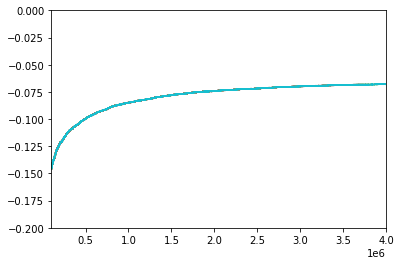

last_avg_reward -0.06795650000000114


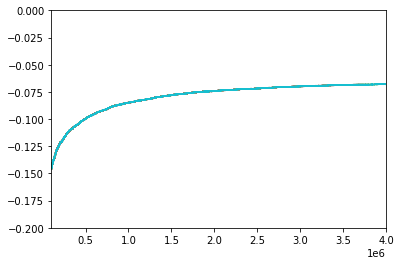

In [20]:
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display

num_states = 3*7*32*11*2
num_actions = 3

def get_code_by_state(state):
    state_dims = [3, 7, 32 ,11, 2]
    size_state, card_state = get_composite_state(state[3][2])
    states = [size_state, card_state, state[0], state[1], (1 if state[2] else 0)]
    state_code = states[0]
    for i in range(1, len(states)):
        state_code = state_code * state_dims[i] + states[i]
    return state_code 

def get_state_by_code(code):
    state_dims = [3, 7, 32 ,11, 2]
    result = []
    for i in range(len(state_dims)-1, -1, -1):
        result.append(code%state_dims[i])
        code = int(code/state_dims[i])
        result.reverse()
    return tuple(result)


def conduct_experiment_double(learning_rate = 0.05, epsilon = 0.1, num_iterations = 100000, plot = False, debug = False):
    print(f'начинаем эксперимент, lr = {learning_rate} epsilon = {epsilon} num_iter = {num_iterations}')
    avg_rewards = []
    q_values = np.zeros((num_states, num_actions))
    states_counter = np.zeros((num_states, num_actions))
    for _ in range(num_iterations):
        state = env.reset()    
        if debug: print("New Game")
        state_code = get_code_by_state(state)
        if debug: print(state, "->", state_code)

        done = False

        while not done:
            action = egreedy_policy(q_values, state_code, epsilon)
            if debug: print("action", action)

            next_state, reward, done, index = env.step_new(action)

            next_state_code = get_code_by_state(next_state)

            if debug: print("next_state", next_state, reward, done, some, next_state_code, q_values[next_state_code][:])
            if debug: print("old value", q_values[state_code][:], reward, np.max(q_values[next_state_code]))            

            q_values[state_code][action] += learning_rate * (reward + np.max(q_values[next_state_code][:] if not done else 0) - q_values[state_code][action])
            states_counter[state_code][action] += 1

            if debug: print("new value", q_values[state_code][:])

            state_code = next_state_code
            if done == True:
                if len(avg_rewards) == 0:
                    avg_rewards.append(reward)
                else:
                    avg_rewards.append((avg_rewards[-1] * len(avg_rewards) + reward)/(len(avg_rewards)+1))

        if len(avg_rewards)%100000 == 0 and plot:
            pl.plot(avg_rewards)
            pl.xlim(100000, num_iterations)
            pl.ylim(-0.2,0)
            display.clear_output(wait=True)
            display.display(pl.gcf())
    print(f'last_avg_reward {avg_rewards[-1]}')
    return avg_rewards, states_counter, q_values


debug = False
env = BlackjackEnv_real(debug)
env.init_deck()
avg_rewards, states_counter, q_values = conduct_experiment_double(learning_rate = 0.02, epsilon = 0.02, num_iterations = 4000000, debug = debug, plot = True)



In [21]:
for i in range(num_states):
    if np.max(states_counter[i][:]) > 0:
        print(get_state_by_code(i), " assessment ", q_values[i][:], states_counter[i], np.argmax(q_values[i]))

(0, 4, 0, 1, 0)  assessment  [-0.02       -0.00065838 -0.04      ] [1. 6. 1.] 1
(0, 4, 0, 2, 0)  assessment  [-0.02  0.    0.  ] [1. 0. 0.] 1
(0, 4, 0, 3, 0)  assessment  [-0.02       -0.00877571 -0.04      ] [1. 5. 1.] 1
(0, 4, 0, 4, 0)  assessment  [-0.02       -0.00286006 -0.00156832] [1. 5. 4.] 2
(0, 4, 0, 5, 0)  assessment  [-0.02       -0.00220978 -0.04153695] [1. 9. 5.] 1
(0, 4, 0, 6, 0)  assessment  [-0.02       -0.00325352 -0.0792    ] [1. 6. 2.] 1
(0, 4, 0, 7, 0)  assessment  [-0.020392   -0.00470362 -0.04      ] [3. 3. 1.] 1
(0, 4, 0, 8, 0)  assessment  [-0.02       -0.00694241 -0.04      ] [1. 8. 1.] 1
(0, 4, 0, 9, 0)  assessment  [-0.02       -0.00240574 -0.04      ] [1. 5. 1.] 1
(0, 4, 0, 10, 0)  assessment  [-0.02221519 -0.0098675  -0.04      ] [9. 5. 1.] 1
(0, 5, 0, 1, 0)  assessment  [-0.02       -0.01205315 -0.04      ] [ 1. 11.  1.] 1
(0, 5, 0, 2, 0)  assessment  [-0.03921584 -0.02060074 -0.04      ] [ 4. 25.  1.] 1
(0, 5, 0, 3, 0)  assessment  [-0.0396     -0.023679

Существенного выигрыша не получилось, либо книга не очень либо программист я фиговый. В обоих случаях книгу смысла нет покупать.

# Задание 4

Реализуйте поиск стратегии в блекджеке с известной моделью из первой части, решив уравнения Беллмана для V* или Q*. Для этого вам придётся сначала оценить параметры модели, т.е. вероятности переходов между состояниями.

Начнем с оценки карт дилера, он может закончить с очками от 17 до 26, для каждого потенциального состояния посчитаем вероятности, очков с которыми он закончит 

In [22]:
num_states =  53
probs_dim = 10

probs_matrix = np.zeros((num_states + 1, probs_dim))

deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def get_state_by_code(code):
  sum = code % 27
  has_ace = True if code>=27 else False
  return sum, has_ace

def get_code_by_state(sum, has_ace):
  return sum + (27 if has_ace else 0)


def calc_score(sum, has_ace):
  if has_ace and sum+10 <= 21:
    return sum + 10
  else:
    return sum


for code in range(num_states, -1, -1):
  sum, has_ace = get_state_by_code(code)
  if calc_score(sum, has_ace) >= 17:
    probs_matrix[code][calc_score(sum, has_ace)-17] = 1
  else:
    for card in deck:
      for i in range(10):
        probs_matrix[code][i] += probs_matrix[get_code_by_state(sum + card, has_ace or card==1)][i] / len(deck)

for i in range(num_states, -1, -1):
  print(np.round(probs_matrix[i],2),  get_state_by_code(i))



[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] (26, True)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] (25, True)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] (24, True)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] (23, True)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] (22, True)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] (21, True)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] (20, True)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] (19, True)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] (18, True)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (17, True)
[0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.31] (16, True)
[0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.31 0.02] (15, True)
[0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.32 0.03 0.03] (14, True)
[0.1  0.1  0.1  0.1  0.1  0.1  0.33 0.04 0.03 0.03] (13, True)
[0.1  0.1  0.1  0.1  0.1  0.33 0.04 0.04 0.03 0.03] (12, True)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] (11, True)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] (10, True)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] (9, True)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] (8, True)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (7, True)
[0.13 0.13 0.13 0.13 0.13 0.07 0.07 0.06 0.

Осталось так же с конца расчитать все за игрока для каждой открытой карты дилера от 1 до 10

In [23]:
def cmp(a, b):
  return float(a > b) - float(a < b)

def get_player_score(sum, has_ace):
  if calc_score(sum, has_ace) > 21:
    return 0
  else:
    return calc_score(sum, has_ace)


# по очкам игрока считаем ev выигрыша против code
def get_EV(player_score, daler_state_code):
  #print(player_score, daler_state_code,probs_matrix[daler_state_code] )
  if player_score >21:
    return -1
  else:
    result = 0
    for i in range(0,10):
      result += cmp(player_score, 17+i if 17 + i <= 21 else 0) * probs_matrix[daler_state_code][i] 
    return result



num_states = 32 * 2 * 11
num_actions = 2

def get_state_by_code_full_game(code):
  dealer_card = code%11
  player_state = int(code/11)
  sum = player_state % 32
  has_ace = True if player_state>=32 else False
  return sum, has_ace, dealer_card

def get_code_by_state_full_game(sum, has_ace, dealer_card):
  return (sum + (32 if has_ace else 0)) * 11 + dealer_card


decision_matrix = np.zeros((num_states + 1, num_actions))


for code in range(num_states - 1, -1, -1):
  sum, has_ace, dealer_card = get_state_by_code_full_game(code)
  if calc_score(sum, has_ace) > 21:
    decision_matrix[code] = np.array([-1,-1])
  else:
    if dealer_card == 1:
      dealer_state_code = get_code_by_state(dealer_card, True)
    else:
      dealer_state_code = get_code_by_state(dealer_card, False)

    print(sum, has_ace,dealer_state_code )
    decision_matrix[code][0] = get_EV(calc_score(sum, has_ace), dealer_state_code)

    for card in deck:
      decision_matrix[code][1] += np.max(decision_matrix[get_code_by_state_full_game(sum + card, has_ace or card==1, dealer_card)]) / len(deck)


for i in range(num_states, -1, -1):
  print(np.round(decision_matrix[i],2),'(player_sum, player_has_ace, dealer_card)' , get_state_by_code_full_game(i))

21 True 10
21 True 9
21 True 8
21 True 7
21 True 6
21 True 5
21 True 4
21 True 3
21 True 2
21 True 28
21 True 0
20 True 10
20 True 9
20 True 8
20 True 7
20 True 6
20 True 5
20 True 4
20 True 3
20 True 2
20 True 28
20 True 0
19 True 10
19 True 9
19 True 8
19 True 7
19 True 6
19 True 5
19 True 4
19 True 3
19 True 2
19 True 28
19 True 0
18 True 10
18 True 9
18 True 8
18 True 7
18 True 6
18 True 5
18 True 4
18 True 3
18 True 2
18 True 28
18 True 0
17 True 10
17 True 9
17 True 8
17 True 7
17 True 6
17 True 5
17 True 4
17 True 3
17 True 2
17 True 28
17 True 0
16 True 10
16 True 9
16 True 8
16 True 7
16 True 6
16 True 5
16 True 4
16 True 3
16 True 2
16 True 28
16 True 0
15 True 10
15 True 9
15 True 8
15 True 7
15 True 6
15 True 5
15 True 4
15 True 3
15 True 2
15 True 28
15 True 0
14 True 10
14 True 9
14 True 8
14 True 7
14 True 6
14 True 5
14 True 4
14 True 3
14 True 2
14 True 28
14 True 0
13 True 10
13 True 9
13 True 8
13 True 7
13 True 6
13 True 5
13 True 4
13 True 3
13 True 2
13 True 28
13

Посчитаем прибыль по стратегии по методу монте-карло

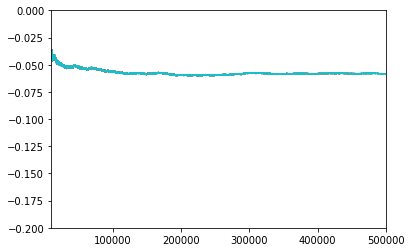

last_avg_reward -0.05839799999999986


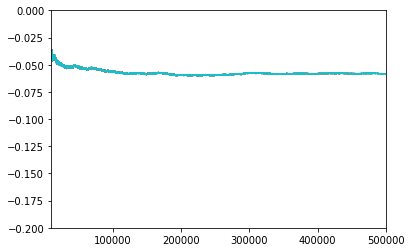

In [24]:
env = gym.make('Blackjack-v0')

import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display


def test_solution(num_iterations = 100000, plot = False, debug = False):
    avg_rewards = []
    for _ in range(num_iterations):
        state = env.reset()    
        if debug: print("New Game")
        state_code = get_code_by_state_full_game(state[0], state[2], state[1])
        if debug: print(state, "->", state_code)

        done = False

        while not done:
            action = np.argmax(decision_matrix[state_code])
            if debug: print("action", action, decision_matrix[state_code])

            state, reward, done, _ = env.step(action)
            state_code = get_code_by_state_full_game(state[0], state[2], state[1])

            if debug: print("next_state", state, reward, done, some, state_code)

            if done == True:
                if len(avg_rewards) == 0:
                    avg_rewards.append(reward)
                else:
                    avg_rewards.append((avg_rewards[-1] * len(avg_rewards) + reward)/(len(avg_rewards)+1))

        if len(avg_rewards)%10000 == 0 and plot:
            pl.plot(avg_rewards)
            pl.xlim(10000, num_iterations)
            pl.ylim(-0.2,0)
            display.clear_output(wait=True)
            display.display(pl.gcf())
    print(f'last_avg_reward {avg_rewards[-1]}')
    return avg_rewards
    
avg_rewards = test_solution(num_iterations = 500000, debug = False, plot = True)